In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
SPLITS = [
    [str(i) for i in range(1, 23) if i % 2 == 1] + ["X"],
    [str(i) for i in range(1, 23) if i % 2 == 0] + ["Y"],
]
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/eqtl/matched/leafcutter"
SPLITS

[['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X'],
 ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']]

In [3]:
models = [
    #"CADD.RawScore",
    #"phyloP",
    #"phastCons",
    #"phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

embedding_models = models[-1:] + [
    #"Enformer",
    #"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,GPN-MSA
0,1,690060,A,C,0.994126,0.038760,True,0,-2.437500
1,1,727717,G,C,0.001489,0.180818,False,90,-1.318359
2,1,792461,G,A,0.008431,0.054545,False,383,-2.121094
3,1,794299,C,G,0.009810,0.229965,False,720,-1.875977
4,1,794707,T,C,0.003659,0.053030,False,330,-1.332031
...,...,...,...,...,...,...,...,...,...
17991,X,154864799,G,A,0.009303,0.017241,False,8936,1.267578
17992,X,155329596,C,T,0.006108,0.282998,False,8822,1.029297
17993,X,155655744,G,A,0.008496,0.291332,False,8995,2.105469
17994,X,155705325,G,A,0.007774,0.471574,False,8923,0.612793


In [4]:
features = {}

for m in embedding_models:
    df = pd.read_parquet(f"../../results/preds/vep_embedding/{dataset_path}/{m}.parquet")
    df.columns = model_renaming.get(m, m) + "_" + df.columns
    if m == "SpliceAI": df = -df.abs()
    features[model_renaming.get(m, m)] = df.columns.values
    V = pd.concat([V, df], axis=1)
embedding_models = [model_renaming.get(m, m) for m in embedding_models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,GPN-MSA,GPN-MSA_embedding_0,...,GPN-MSA_embedding_758,GPN-MSA_embedding_759,GPN-MSA_embedding_760,GPN-MSA_embedding_761,GPN-MSA_embedding_762,GPN-MSA_embedding_763,GPN-MSA_embedding_764,GPN-MSA_embedding_765,GPN-MSA_embedding_766,GPN-MSA_embedding_767
0,1,690060,A,C,0.994126,0.038760,True,0,-2.437500,88.732262,...,69.969208,159.564148,57.168053,102.719284,58.549225,100.034698,123.556252,244.035736,123.669830,91.900497
1,1,727717,G,C,0.001489,0.180818,False,90,-1.318359,127.015015,...,151.119354,289.776581,75.378304,122.505402,32.291225,79.828705,45.644417,138.381699,31.264908,94.553024
2,1,792461,G,A,0.008431,0.054545,False,383,-2.121094,82.676003,...,62.109013,207.978271,47.711388,219.310715,84.289383,103.947014,88.183136,319.545959,98.325584,79.933273
3,1,794299,C,G,0.009810,0.229965,False,720,-1.875977,111.722153,...,106.391144,252.772980,57.824459,110.372299,35.708862,47.625103,54.360565,168.280945,36.307438,130.848114
4,1,794707,T,C,0.003659,0.053030,False,330,-1.332031,79.782501,...,65.242012,305.883789,57.496223,178.101501,62.806454,46.592236,24.006680,264.435699,103.300499,80.988815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,X,154864799,G,A,0.009303,0.017241,False,8936,1.267578,119.544205,...,69.329147,243.558472,24.861374,247.200195,47.784061,66.633461,47.677147,287.063110,111.856949,69.145805
17992,X,155329596,C,T,0.006108,0.282998,False,8822,1.029297,132.926086,...,61.526295,140.302383,54.453293,192.621384,86.354759,119.843735,79.652405,260.624390,113.272369,87.806633
17993,X,155655744,G,A,0.008496,0.291332,False,8995,2.105469,276.704376,...,101.864746,525.180481,46.841408,234.738647,97.636337,111.047920,238.590790,269.950226,225.214447,75.911255
17994,X,155705325,G,A,0.007774,0.471574,False,8923,0.612793,177.328613,...,73.210724,530.341919,46.872234,293.757111,65.687271,89.036865,74.217377,335.931763,77.696716,46.595848


In [5]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [6]:
V.dropna(
    subset=models + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,match_group,GPN-MSA,GPN-MSA_embedding_0,...,GPN-MSA_embedding_758,GPN-MSA_embedding_759,GPN-MSA_embedding_760,GPN-MSA_embedding_761,GPN-MSA_embedding_762,GPN-MSA_embedding_763,GPN-MSA_embedding_764,GPN-MSA_embedding_765,GPN-MSA_embedding_766,GPN-MSA_embedding_767
0,1,690060,A,C,0.994126,0.038760,True,0,-2.437500,88.732262,...,69.969208,159.564148,57.168053,102.719284,58.549225,100.034698,123.556252,244.035736,123.669830,91.900497
1,1,727717,G,C,0.001489,0.180818,False,90,-1.318359,127.015015,...,151.119354,289.776581,75.378304,122.505402,32.291225,79.828705,45.644417,138.381699,31.264908,94.553024
2,1,792461,G,A,0.008431,0.054545,False,383,-2.121094,82.676003,...,62.109013,207.978271,47.711388,219.310715,84.289383,103.947014,88.183136,319.545959,98.325584,79.933273
3,1,794299,C,G,0.009810,0.229965,False,720,-1.875977,111.722153,...,106.391144,252.772980,57.824459,110.372299,35.708862,47.625103,54.360565,168.280945,36.307438,130.848114
4,1,794707,T,C,0.003659,0.053030,False,330,-1.332031,79.782501,...,65.242012,305.883789,57.496223,178.101501,62.806454,46.592236,24.006680,264.435699,103.300499,80.988815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,X,154864799,G,A,0.009303,0.017241,False,8936,-1.267578,119.544205,...,69.329147,243.558472,24.861374,247.200195,47.784061,66.633461,47.677147,287.063110,111.856949,69.145805
17992,X,155329596,C,T,0.006108,0.282998,False,8822,-1.029297,132.926086,...,61.526295,140.302383,54.453293,192.621384,86.354759,119.843735,79.652405,260.624390,113.272369,87.806633
17993,X,155655744,G,A,0.008496,0.291332,False,8995,-2.105469,276.704376,...,101.864746,525.180481,46.841408,234.738647,97.636337,111.047920,238.590790,269.950226,225.214447,75.911255
17994,X,155705325,G,A,0.007774,0.471574,False,8923,-0.612793,177.328613,...,73.210724,530.341919,46.872234,293.757111,65.687271,89.036865,74.217377,335.931763,77.696716,46.595848


In [7]:
V = V[V.duplicated("match_group", keep=False)]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,GPN-MSA,GPN-MSA_embedding_0,...,GPN-MSA_embedding_758,GPN-MSA_embedding_759,GPN-MSA_embedding_760,GPN-MSA_embedding_761,GPN-MSA_embedding_762,GPN-MSA_embedding_763,GPN-MSA_embedding_764,GPN-MSA_embedding_765,GPN-MSA_embedding_766,GPN-MSA_embedding_767
0,1,690060,A,C,0.994126,0.038760,True,0,-2.437500,88.732262,...,69.969208,159.564148,57.168053,102.719284,58.549225,100.034698,123.556252,244.035736,123.669830,91.900497
1,1,727717,G,C,0.001489,0.180818,False,90,-1.318359,127.015015,...,151.119354,289.776581,75.378304,122.505402,32.291225,79.828705,45.644417,138.381699,31.264908,94.553024
2,1,792461,G,A,0.008431,0.054545,False,383,-2.121094,82.676003,...,62.109013,207.978271,47.711388,219.310715,84.289383,103.947014,88.183136,319.545959,98.325584,79.933273
3,1,794299,C,G,0.009810,0.229965,False,720,-1.875977,111.722153,...,106.391144,252.772980,57.824459,110.372299,35.708862,47.625103,54.360565,168.280945,36.307438,130.848114
4,1,794707,T,C,0.003659,0.053030,False,330,-1.332031,79.782501,...,65.242012,305.883789,57.496223,178.101501,62.806454,46.592236,24.006680,264.435699,103.300499,80.988815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,X,154864799,G,A,0.009303,0.017241,False,8936,-1.267578,119.544205,...,69.329147,243.558472,24.861374,247.200195,47.784061,66.633461,47.677147,287.063110,111.856949,69.145805
17992,X,155329596,C,T,0.006108,0.282998,False,8822,-1.029297,132.926086,...,61.526295,140.302383,54.453293,192.621384,86.354759,119.843735,79.652405,260.624390,113.272369,87.806633
17993,X,155655744,G,A,0.008496,0.291332,False,8995,-2.105469,276.704376,...,101.864746,525.180481,46.841408,234.738647,97.636337,111.047920,238.590790,269.950226,225.214447,75.911255
17994,X,155705325,G,A,0.007774,0.471574,False,8923,-0.612793,177.328613,...,73.210724,530.341919,46.872234,293.757111,65.687271,89.036865,74.217377,335.931763,77.696716,46.595848


In [8]:
V.label.value_counts()

label
True     8998
False    8998
Name: count, dtype: int64

In [9]:
def train_predict_best_inner_product(V_train, V_test, features):
    results_train = pd.DataFrame([
        [f, roc_auc_score(V_train.label, -V_train[f])]
        for f in tqdm(features)
    ], columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', LogisticRegressionCV(
            random_state=42,
            scoring="roc_auc",
            n_jobs=-1,
            max_iter=1000,
            Cs=np.logspace(-5, 0, 10),
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    linear = clf.named_steps["linear"]
    C = linear.C_
    Cs = linear.Cs_
    #if C == Cs[0] or C == Cs[-1]:
    #    raise Exception(f"{C=} {Cs[0]=} {Cs[-1]=}")
    return -clf.predict_proba(V_test[features])[:, 1]

supervised_models = []

for m in embedding_models:
    supervised_models.append((
        f"{m} - best inner product",
        lambda *args, m=m: train_predict_best_inner_product(*args, features[m]),
    ))
    supervised_models.append((
        f"{m} - LR(inner products)",
        lambda *args, m=m: train_predict_lr(*args, features[m]),
    ))

#supervised_models.append((
#    f"GPN-MSA + Enformer - LR(inner products+abs(delta features))",
#    lambda *args: train_predict_lr(*args, np.concatenate([features["GPN-MSA"], features["Enformer"]])),
#))

for split in SPLITS:
    print(split)
    mask_train = V.chrom.isin(split)
    mask_test = ~mask_train
    for model_name, model in supervised_models:
        print(model_name)
        if model_name not in models: models.append(model_name)
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])

['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X']
GPN-MSA - best inner product


100%|██████████| 768/768 [00:03<00:00, 243.45it/s]


GPN-MSA - LR(inner products)
['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']
GPN-MSA - best inner product


100%|██████████| 768/768 [00:02<00:00, 272.90it/s]


GPN-MSA - LR(inner products)


## Testing

In [10]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC])
results = pd.DataFrame(rows, columns=["Model", "AUROC"])
results

100%|██████████| 3/3 [00:00<00:00, 104.03it/s]


,Model,AUROC
0,GPN-MSA,0.545185
1,GPN-MSA - best inner product,0.689098
2,GPN-MSA - LR(inner products),0.725502


In [11]:
#results.to_csv("results_sqtl.csv", index=False)

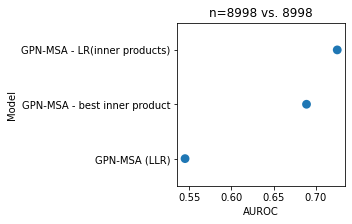

In [12]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("AUROC", ascending=False).replace({
        "Enformer_l2": "Enformer",
        "GPN-MSA": "GPN-MSA (LLR)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);